In [2]:
#Efficient Data Selection via Proxy

from tensorflow.keras import datasets, layers, models, regularizers, preprocessing, optimizers
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#load CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [4]:
#build Train Proxy Model
train_prox_model = models.Sequential()
train_prox_model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same', input_shape=(32,32,3)))
train_prox_model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_prox_model.add(layers.MaxPooling2D((2,2)))
train_prox_model.add(layers.Dropout(0.2))
train_prox_model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_prox_model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_prox_model.add(layers.MaxPooling2D((2,2)))
train_prox_model.add(layers.Dropout(0.2))
train_prox_model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_prox_model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_prox_model.add(layers.MaxPooling2D((2,2)))
train_prox_model.add(layers.Dropout(0.2))
train_prox_model.add(layers.Flatten())
train_prox_model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
train_prox_model.add(layers.Dropout(0.2))
train_prox_model.add(layers.Dense(10, activation='softmax'))


#build Train Target Model
train_target_model = models.Sequential()
train_target_model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',padding='same', input_shape=(32,32,3)))
train_target_model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_target_model.add(layers.MaxPooling2D((2,2)))
train_target_model.add(layers.Dropout(0.2))
train_target_model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_target_model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_target_model.add(layers.MaxPooling2D((2,2)))
train_target_model.add(layers.Dropout(0.2))
train_target_model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_target_model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
train_target_model.add(layers.MaxPooling2D((2,2)))
train_target_model.add(layers.Dropout(0.2))
train_target_model.add(layers.Flatten())
train_target_model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
train_target_model.add(layers.Dropout(0.2))
train_target_model.add(layers.Dense(10, activation='softmax'))



Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [ ]:
#train the proxy model
trainLabels = tf.keras.utils.to_categorical(train_labels)
testLabels = tf.keras.utils.to_categorical(test_labels)

LearningRate = optimizers.schedules.CosineDecay(0.005, 100*train_images.shape[0],0.002)
opt = SGD(LearningRate, momentum=0.9)

train_prox_model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

train_prox_model.fit(train_images, train_labels, epochs=30,
                    validation_data=(test_images, test_labels))


In [6]:
#evaluate the proxy model
test_loss, test_acc = train_prox_model.evaluate(test_images,  test_labels)

313/313 [==============================] - 3s 8ms/step - loss: 0.6365 - accuracy: 0.8116


In [7]:
core_set_for_each_class = False

# Compute entropy for each example
entropy_scores = train_prox_model.predict(train_images)
entropy = -np.sum(entropy_scores * np.log2(entropy_scores), axis=1)
num_examples = len(train_images)
if not core_set_for_each_class : 
    # Select the examples with the highest entropy
    core_set_size = int(num_examples * 0.5)  # Select 50% of the examples
    core_set_indices = np.argsort(entropy)[-core_set_size:]

   

else : 

    # Select 50% of each label based on entropy
    num_classes = 10  # Assuming there are 10 classes in the dataset
    core_set_size_per_class = int(num_examples * 0.5 / num_classes)  # Select 50% of each label
    core_set_indices = []
    for class_label in range(num_classes):
        class_indices = np.where(train_labels == class_label)[0]
        class_entropy = entropy[class_indices]
        class_core_set_indices = class_indices[np.argsort(class_entropy)[-core_set_size_per_class:]]
        core_set_indices.extend(class_core_set_indices)


 # Create the core set
core_set_images = train_images[core_set_indices]
core_set_labels = train_labels[core_set_indices]


1563/1563 [==============================] - 8s 5ms/step


/var/folders/kk/zm9ccw9146n2vhb0zj4mtggr0000gn/T/ipykernel_25640/575071711.py:5: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(entropy_scores * np.log2(entropy_scores), axis=1)
/var/folders/kk/zm9ccw9146n2vhb0zj4mtggr0000gn/T/ipykernel_25640/575071711.py:5: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(entropy_scores * np.log2(entropy_scores), axis=1)


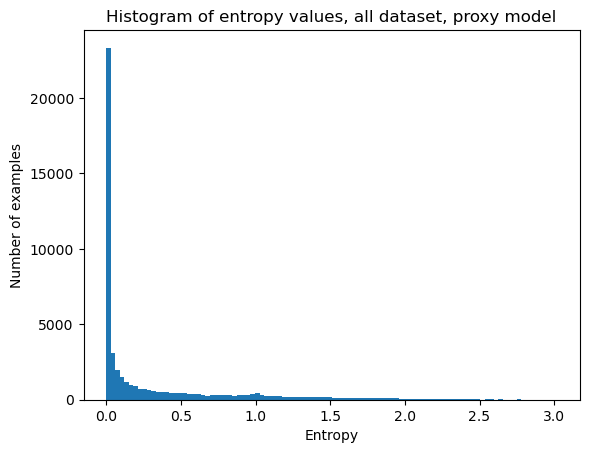

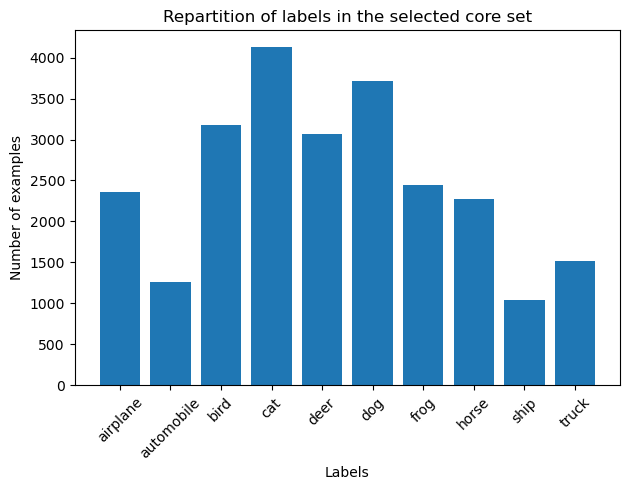

In [8]:
#histogram of entropies values, plot a line at 50%
plt.hist(entropy, bins=100)
plt.xlabel('Entropy')
plt.ylabel('Number of examples')
plt.title('Histogram of entropy values, all dataset, proxy model')
plt.show()


#repartition of number of samples of set core per labels, there are 10 labels in cifar 10
core_set_labels_flat = core_set_labels.flatten()
plt.bar(np.arange(10), np.bincount(core_set_labels_flat))


#plt.hist(core_set_labels, bins=10)
plt.xlabel('Labels')
plt.ylabel('Number of examples')    
plt.xticks(np.arange(10), ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck'), rotation=45, ha='center')
plt.tight_layout()
plt.title('Repartition of labels in the selected core set')
plt.show()


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy


#clone the target model
core_set_train_target_model = tf.keras.models.clone_model(train_prox_model)
all_set_train_target_model = tf.keras.models.clone_model(train_prox_model)


#train the proxy model
n_epochs = 50
trainLabels = tf.keras.utils.to_categorical(train_labels)
trainLabelsCoreSet = tf.keras.utils.to_categorical(core_set_labels)
testLabels = tf.keras.utils.to_categorical(test_labels)

LearningRate = optimizers.schedules.CosineDecay(0.005, 100*train_images.shape[0],0.002)
opt = tf.keras.optimizers.legacy.SGD(LearningRate, momentum=0.9)

core_set_train_target_model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

core_set_training_history = core_set_train_target_model.fit(train_images, train_labels, epochs=2*n_epochs,
                    validation_data=(test_images, test_labels))

all_set_train_target_model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

all_set_training_history = all_set_train_target_model.fit(train_images, train_labels, epochs=n_epochs,
                    validation_data=(test_images, test_labels))


In [ ]:
plt.plot(np.arange(0, n_epochs*train_images.shape[0],train_images.shape[0]//2), core_set_training_history.history['accuracy'], label='Core Set Training Accuracy', color='red')
plt.plot(np.arange(0, n_epochs*train_images.shape[0],train_images.shape[0]//2), core_set_training_history.history['val_accuracy'], label='Core Set Validation Accuracy', color='red', linestyle='dashed')
plt.plot(np.arange(0, n_epochs*train_images.shape[0],train_images.shape[0]), all_set_training_history.history['accuracy'], label='All Data Training Accuracy', color='blue')
plt.plot(np.arange(0, n_epochs*train_images.shape[0],train_images.shape[0]), all_set_training_history.history['val_accuracy'], label='All Data Validation Accuracy', color='blue', linestyle='dashed')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Comparison of training and validation accuracy for core set and all data training')
plt.legend()
plt.show()


In [63]:
#save history 
np.save('core_set_training_history.npy', core_set_training_history.history)
np.save('all_set_training_history.npy', all_set_training_history.history)